In [1]:
import sys,os
import datetime 
import warnings
import subprocess
import numpy               as     np
import pandas              as     pd
import xarray              as     xr
import matplotlib.pyplot   as     plt
import matplotlib.gridspec as     gridspec
from   matplotlib.colors   import ListedColormap
import cartopy.crs         as     crs
import cartopy.io.shapereader  as shpreader
import cartopy.feature     as     cfeature
import seaborn             as     sns
from   netCDF4             import Dataset
from   wrf                 import ( getvar, latlon_coords,to_np)
from   base_information    import (usa_feature,us_states_filtered, cart_proj, cmap_acc, lats, lons,# For ploting figures.
                                path_static,path_combine                                            ,# Information of file path.
                                years,)
print('Library have loaded!')

/home/umd-gwli/anaconda3/envs/work/lib/python3.8/site-packages/xclim/indices/fire/_cffwis.py:207: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/home/umd-gwli/anaconda3/envs/work/lib/python3.8/site-packages/xclim/indices/fire/_cffwis.py:227: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_le

Library have loaded!


In [2]:
## Information of path and loop index
path_obs_monthly  = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/OBS/regrid_monthly/'
path_cwrf_hindcast= '/scratch16/umd-xliang/shinsa11/Exp2023Dec_NonBC/CWRF-post/'
path_climatology  = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/cwrf_operational/climatology/'
path_operational  = '/scratch16/umd-xliang/aditya/cwrf_operational/CWRF-post/V0/'
path_adjustment   = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CWRF_v0_adjustment/'
path_CFS_monthly  = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/CFS/regrid_full_monthly/'
static_path       = '/scratch16/umd-xliang/CFS_seasonal_forecast/DATA/static/'
MASK_US           = xr.open_dataset(f'{static_path}US_MASK_logic.nc')['MASK']

var_names         = ['T2MAX','T2MIN','PRAVG']
years             = range(2012,2023+1)
months            = range(1,12+1)
exps              = ['00','02']

# days that CWRF hindcast runs for each month. It is the right one.
days_per_month    = {
    1: [ 1, 6,11,16,21,26,31],
    2: [ 5,10,15,20,25],
    3: [ 2, 7,12,17,22,27],
    4: [ 1, 6,11,16,21,26],
    5: [ 1, 6,11,16,21,26,31],
    6: [ 5,10,15,20,25,30],
    7: [ 5,10,15,20,25,30],
    8: [ 4, 9,14,19,24,29],
    9: [ 3, 8,13,18,23,28],
    10:[ 3, 8,13,18,23,28],
    11:[ 2, 7,12,17,22,27],
    12:[ 2, 7,12,17,22,27],
}

month_to_delete   = {
    1:[8,9,10,11,12],
    2:[9,10,11,12, 1],
    3:[10,11,12, 1, 2],
    4:[11,12,1, 2, 3],
    5:[12,1,2, 3, 4],
    6:[1,2,3, 4, 5],
    7:[2,3,4, 5, 6],
    8:[3,4,5, 6, 7],
    9:[4,5,6, 7, 8],
    10:[5,6,7,8, 9],
    11:[6,7,8,9,10],
    12:[7,8,9,10,11],
}


In [14]:
def contour_plot(data,cmap_in,levels,title_str):
    # Create a figure and axis with the AlbersEqualArea projection
    # fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(projection=cart_proj))
    fig, ax       = plt.subplots(figsize=(6, 3), subplot_kw=dict(projection=cart_proj))
    ax.add_feature(usa_feature)
    ax.add_feature(us_states_filtered)    
    # Plot the data with the specified contour levels and custom colormap
    plt.contourf(to_np(lons), to_np(lats), to_np(US_MASK(data)),
                 transform = crs.PlateCarree(),levels=levels,cmap=cmap_in,extend='both')
    # Add a color bar
    plt.colorbar(ax=ax, shrink=1.0)
    plt.title(title_str)
    # Zoom in on a specific region by setting a custom extent
    ax.set_extent([-120.5, -74, 25.1, 48.8], crs=crs.PlateCarree())
    # plt.title("Sea Level Pressure (hPa)")
    cb_masked_data= CB_MASK(data)
    cb_mean_value = cb_masked_data.mean().values.item()  # Use .item() to get a pure Python float
    color = 'red' if cb_mean_value >= 0 else 'blue'
    ax.text(0.03, 0.03, f"{cb_mean_value:.2f}", transform=ax.transAxes, color=color, fontsize=14, verticalalignment='bottom', horizontalalignment='left')
    return plt
    plt.close()
def US_MASK(data):
    # Read the MASK information
    ds_mask       = xr.open_dataset(f'{path_static}US_MASK.nc')
    US_MASK_da    = ds_mask['MASK']
    return xr.where(US_MASK_da == 1, data, np.nan )
def CB_MASK(data):
    # Read the MASK information
    CB_MASK       = xr.open_dataset(f'{path_static}CB_MASK_logic.nc')['MASK']
    return xr.where(CB_MASK == 1, data, np.nan )

def cmap_normalize(cmap_RGB):
    return [(r/255, g/255, b/255) for r, g, b in cmap_RGB]

# MY list of RGB colors --- for Temperature
cmap_RGB_TEMP     = [( 24,  24, 107),  ( 36,  77, 134),  ( 82, 117, 246),
                     ( 111, 170, 231),  (214, 236, 236),  (244, 255, 255), (252, 245, 231),
                     (250, 229, 186),  (232, 167, 108),  (192, 107,  49), (217,  49,  32),
                     (127,  23,   14) ]
cmap_temp        = ListedColormap( cmap_normalize(cmap_RGB_TEMP) )
levels_temp      = [0.0,1.0,2.0, 3.0,4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
levels           = [x*2+278 for x in levels_temp]


cmap_RGB_TEMP_diff= [( 13,  30,  67),   ( 34,  81, 151),  ( 87, 144, 194),
                     (136, 189, 211),   (224, 244, 254),  (255, 255, 255), (255, 255, 255),
                     (252, 240, 245),   (242, 189, 173),  (233, 115,  84), (187,  47,  42),
                     (110,  24,  22) ]
cmap_temp_diff    = ListedColormap( cmap_normalize(cmap_RGB_TEMP_diff) )
levels_temp_diff  = [-5.0,-4.0,-3.0, -2.0,-1.0, -0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
fig_fmt = 'png'



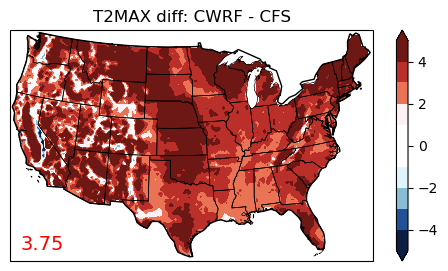

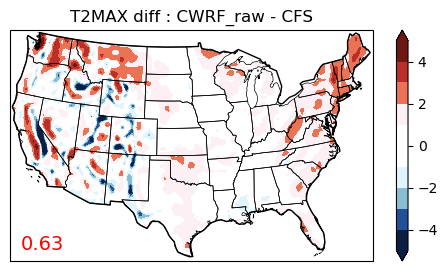

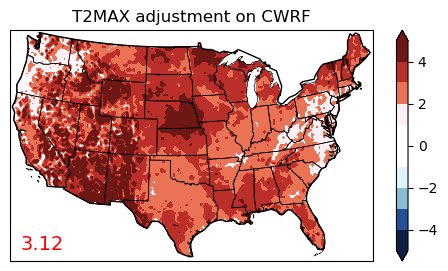

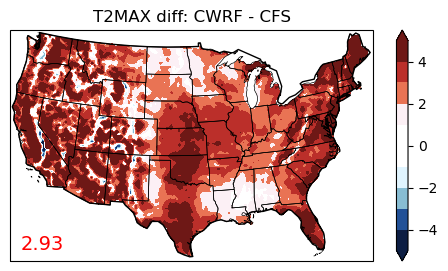

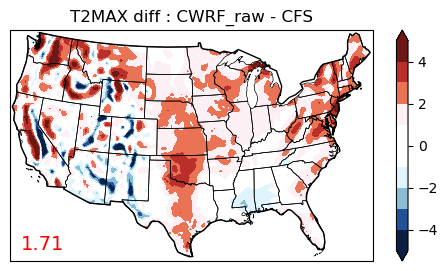

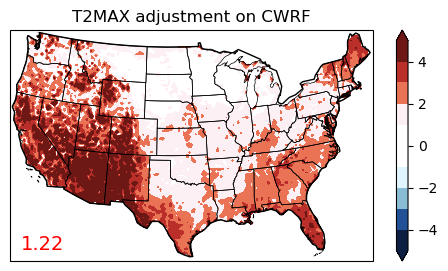

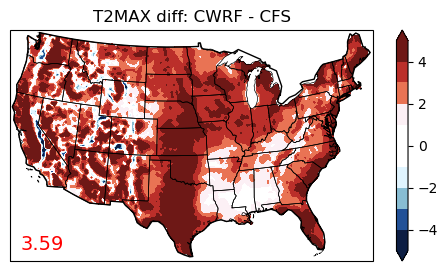

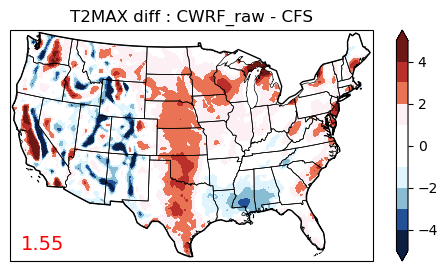

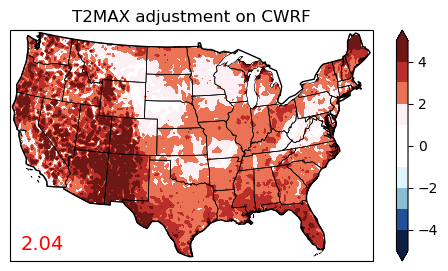

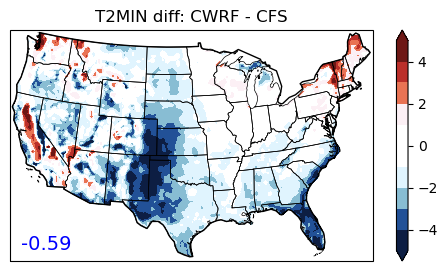

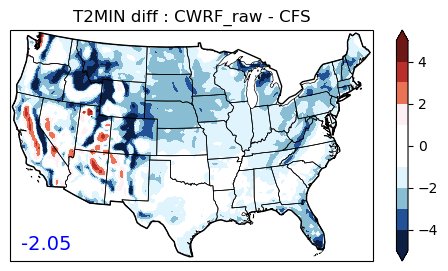

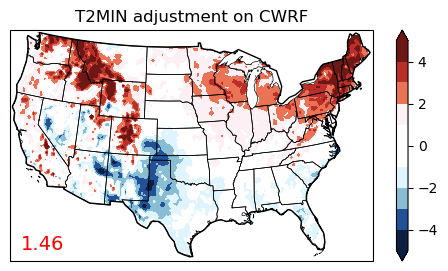

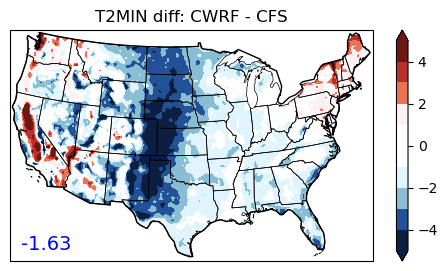

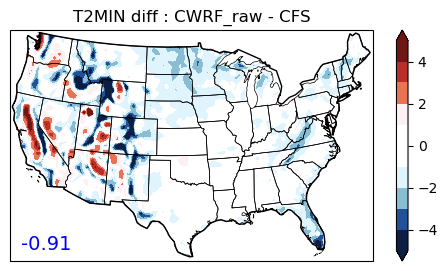

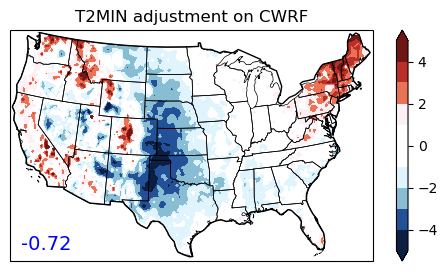

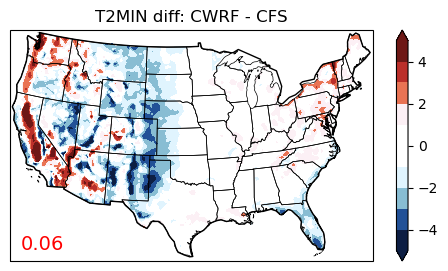

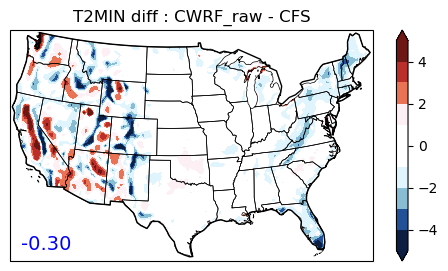

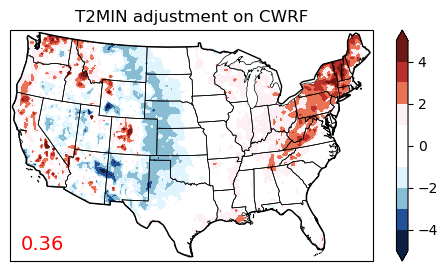

In [16]:
# Read the data, and calculate the ensemble mean
month     = 1 
exp       = exps[0]
days      = days_per_month[month]
for var_name  in var_names[0:2]:

    #CWRF
    file_list     = []
    for day in days:
        file_name = f'{path_adjustment}2024{month:02}{day:02}_icbc01_ensemble_mean_{var_name}_daily.nc'
        if os.path.exists(file_name):
            file_list.append(file_name)
    # The 'concat_dim' will be a new dimension we are adding, named 'ensemble' in this case.
    ds_data       = xr.open_mfdataset(file_list, concat_dim='ensemble', combine='nested')
    ds_cwrf       = ds_data.mean(dim='ensemble').squeeze('bottom_top',drop=True).resample(time='1M').mean()

    #CWRF_noadj
    file_list     = []
    for day in days:
        file_name = f'{path_adjustment}2024{month:02}{day:02}_icbc01_ensemble_mean_{var_name}_daily_no_adj.nc'
        if os.path.exists(file_name):
            file_list.append(file_name)
    # The 'concat_dim' will be a new dimension we are adding, named 'ensemble' in this case.
    ds_data       = xr.open_mfdataset(file_list, concat_dim='ensemble', combine='nested')
    ds_cwrfnoadj  = ds_data.mean(dim='ensemble').squeeze('bottom_top',drop=True).resample(time='1M').mean()


    #CFS
    file_list     = []
    for day in days:
        file_name = f'{path_CFS_monthly}CFS_full_time_{var_name}_2024-{month:02}-{day:02}-06.nc'
        if os.path.exists(file_name):
            file_list.append(file_name)
    # The 'concat_dim' will be a new dimension we are adding, named 'ensemble' in this case.
    ds_data       = xr.open_mfdataset(file_list, concat_dim='ensemble', combine='nested')
    ds_cfs        = ds_data.mean(dim='ensemble')

    # Plot the figure
    for predic_month in range(3,5+1):
        da_cwrf          = ds_cwrf.sel(time = ds_cwrf['time'].dt.month == predic_month).squeeze('time')[var_name]
        da_cwrf_noadj    = ds_cwrfnoadj.sel(time = ds_cwrfnoadj['time'].dt.month == predic_month).squeeze('time')[var_name]
        da_cfs           = ds_cfs.sel( time = ds_cfs['time'].dt.month == predic_month).squeeze('time')[var_name]
        diff_cwrf_cfs    = da_cwrf - da_cfs
        diff_noadj_cfs   = da_cwrf_noadj - da_cfs
        diff_adj         = da_cwrf - da_cwrf_noadj  

        title_str = f'{var_name} diff: CWRF - CFS'
        contour_plot(diff_cwrf_cfs,cmap_temp_diff,levels_temp_diff,title_str).savefig(f'./Figures/{var_name}_tgt{predic_month}_cwrf_diff.{fig_fmt}',dpi=150, bbox_inches='tight',format=fig_fmt)
        title_str = f'{var_name} diff : CWRF_raw - CFS'
        contour_plot(diff_noadj_cfs,cmap_temp_diff,levels_temp_diff,title_str).savefig(f'./Figures/{var_name}_tgt{predic_month}_cwrfraw_diff.{fig_fmt}',dpi=150, bbox_inches='tight',format=fig_fmt)
        title_str = f'{var_name} adjustment on CWRF'
        contour_plot(diff_adj,cmap_temp_diff,levels_temp_diff,title_str).savefig(f'./Figures/{var_name}_tgt{predic_month}_adjustment.{fig_fmt}',dpi=150, bbox_inches='tight',format=fig_fmt)
